129L Section 2 <br>
1/14-16/25 <br>
William Melby

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from mpl_toolkits.mplot3d import Axes3D
import csv
import time 
from collections import Counter
from scipy.spatial import Delaunay
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

**Task 1**: Convex hull in 2D

**Part a) Visualize Data**

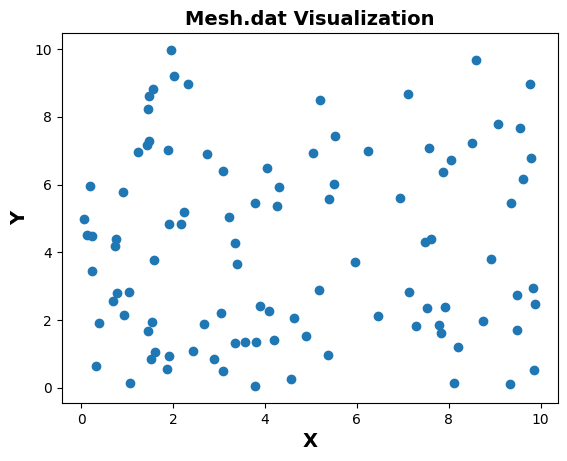

In [2]:
# Load the .dat file
data = pd.read_csv("mesh.dat", delimiter=" ")  # Adjust the delimiter based on file format

# Plot the data
plt.plot(data['X'], data['Y'], marker='o', linestyle=' ')
plt.xlabel("X", fontsize=14, fontweight='bold')
plt.ylabel("Y", fontsize=14, fontweight='bold')
plt.title("Mesh.dat Visualization", fontsize=14, fontweight='bold')
plt.show()

**Part b) Build Functions**

In [25]:
def get_cross_product(p1, p2, p3):
    """ Compute cross product of vectors (p1->p2) and (p1->p3). """
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def get_slope(p1, p2):
    if p1[0] == p2[0]:
        return float('inf')
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

In [19]:
# 2D Graham Scan
def graham_convex_hull(points):
    # Step 1: Sort the points
    points.sort(key=lambda x: (x[0], x[1]))
    
    # Step 2: Get the start point (lowest lexicographical point)
    start = points.pop(0)
    hull = [start]

    # Step 3: Sort remaining points based on polar angle with the start point
    points.sort(key=lambda p: (get_slope(start, p), p[1], p[0]))

    # Step 4: Build the hull
    for pt in points:
        hull.append(pt)
        # Ensure convexity by checking the cross product
        while len(hull) > 2 and get_cross_product(hull[-3], hull[-2], hull[-1]) < 0:
            hull.pop(-2)
    
    return hull

In [26]:
def jarvis_march(points):
    """ Compute the convex hull using Jarvis March algorithm. """
    if len(points) < 3:
        return points  # Convex hull is trivial for <= 2 points.

    # Step 1: Find the leftmost point (smallest x, break ties with y)
    start = min(points, key=lambda p: (p[0], p[1]))
    hull = [start]
    
    while True:
        next_point = points[0]  # Assume first point is next hull point
        for p in points:
            if p == hull[-1]:
                continue
            cross = get_cross_product(hull[-1], next_point, p)
            if cross > 0 or (cross == 0 and (p != hull[-1] and p != next_point)):
                next_point = p  # Select the most counterclockwise point
                
        if next_point == start:
            break  # Hull is closed
        hull.append(next_point)
    
    return hull

In [43]:
def get_distance(p1, p2, p3):
    """ Compute the perpendicular distance from p3 to the line p1-p2. """
    return abs(get_cross_product(p1, p2, p3)) / ((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2) ** 0.5

def find_hull(points, p1, p2, side):
    """ Recursively find the convex hull points in order. """
    if not points:
        return []
    
    # Find the farthest point
    farthest = max(points, key=lambda p: get_distance(p1, p2, p))
    
    # Split points into two subsets
    left_of_farthest = [p for p in points if get_cross_product(p1, farthest, p) > 0]
    right_of_farthest = [p for p in points if get_cross_product(farthest, p2, p) > 0]

    # Recursively find hull points, ensuring order
    return find_hull(left_of_farthest, p1, farthest, -side) + [farthest] + find_hull(right_of_farthest, farthest, p2, -side)

def quickhull(points):
    """ Compute the convex hull using Quickhull algorithm, ensuring correct point order. """
    if len(points) < 3:
        return points  # Convex hull is trivial for <= 2 points.

    # Find leftmost and rightmost points
    min_x = min(points, key=lambda p: p[0])
    max_x = max(points, key=lambda p: p[0])

    # Find hull points in order
    upper_hull = find_hull([p for p in points if get_cross_product(min_x, max_x, p) > 0], min_x, max_x, 1)
    lower_hull = find_hull([p for p in points if get_cross_product(max_x, min_x, p) > 0], max_x, min_x, -1)

    # Return ordered hull, starting from min_x, through upper hull, max_x, and then lower hull
    return [min_x] + upper_hull + [max_x] + lower_hull

In [28]:
def monotone_chain(points):
    """ Compute the convex hull using Monotone Chain algorithm. """
    if len(points) < 3:
        return points  # Convex hull is trivial for <= 2 points.

    # Step 1: Sort points lexicographically (by x, then by y)
    points.sort()

    # Step 2: Build the lower hull
    lower_hull = []
    for p in points:
        while len(lower_hull) >= 2 and get_cross_product(lower_hull[-2], lower_hull[-1], p) <= 0:
            lower_hull.pop()
        lower_hull.append(p)

    # Step 3: Build the upper hull
    upper_hull = []
    for p in reversed(points):
        while len(upper_hull) >= 2 and get_cross_product(upper_hull[-2], upper_hull[-1], p) <= 0:
            upper_hull.pop()
        upper_hull.append(p)

    # Step 4: Remove duplicate endpoints and return the result
    return lower_hull[:-1] + upper_hull[:-1]

**Part c) Visualize Convex Hulls**

In [29]:
def read_points_from_file(filename):
    points = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        next(reader)  # Skip the first row (header)
        for row in reader:
            # Convert the x, y values to floats and append as a tuple
            points.append((float(row[0]), float(row[1])))
            
    return points

In [30]:
points = read_points_from_file('mesh.dat')
print(points)

[(7.886064, 6.359793), (2.321047, 8.954139), (0.24177, 4.484384), (8.585893, 9.667951), (0.733972, 4.184429), (0.066917, 4.989909), (5.171782, 2.894169), (7.783637, 1.84363), (3.079366, 6.398785), (1.554935, 8.822333), (7.565876, 7.070832), (9.360976, 5.455807), (8.49718, 7.212187), (5.398867, 5.557717), (0.220598, 3.450224), (1.905661, 4.84865), (0.937792, 2.15556), (3.774648, 0.053429), (0.686874, 2.569727), (4.6301, 2.044686), (2.014782, 9.196666), (1.952346, 9.973366), (1.598117, 1.064985), (2.726009, 6.897824), (9.075066, 7.777463), (7.286463, 1.818542), (1.482872, 8.62572), (3.355591, 1.313981), (9.791283, 6.778667), (9.339696, 0.11398), (0.128699, 4.507505), (1.241003, 6.952584), (9.490763, 1.718606), (6.946763, 5.600338), (4.204096, 1.409201), (7.910727, 2.396039), (4.078636, 2.251945), (7.132603, 2.817208), (0.381927, 1.908477), (1.475566, 7.283013), (3.347119, 4.274362), (7.524107, 2.346317), (5.964628, 3.712528), (3.568954, 1.358731), (2.177939, 4.827777), (3.891618, 2.39865

In [38]:
graham_hull = graham_convex_hull(points)
jarvis_hull = jarvis_march(points)
quick_hull = quickhull(points)
monotone_hull = monotone_chain(points)

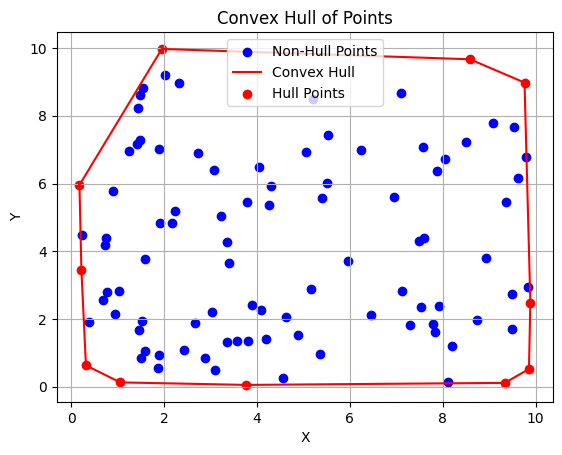

In [45]:
def plot_points_with_hull(points, hull):
    # Separate the points on the convex hull from the others
    hull_set = set(hull)
    non_hull_points = [pt for pt in points if pt not in hull_set]
    
    # Plot all points (non-hull points in one color)
    x_non_hull, y_non_hull = zip(*non_hull_points) if non_hull_points else ([], [])
    plt.scatter(x_non_hull, y_non_hull, color='blue', label='Non-Hull Points')
    
    # Plot the convex hull points (different color, connected by lines)
    x_hull, y_hull = zip(*hull)
    plt.plot(x_hull + (x_hull[0],), y_hull + (y_hull[0],), color='red', label='Convex Hull')
    plt.scatter(x_hull, y_hull, color='red', marker='o', label='Hull Points')
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Convex Hull of Points')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_points_with_hull(points, graham_hull)

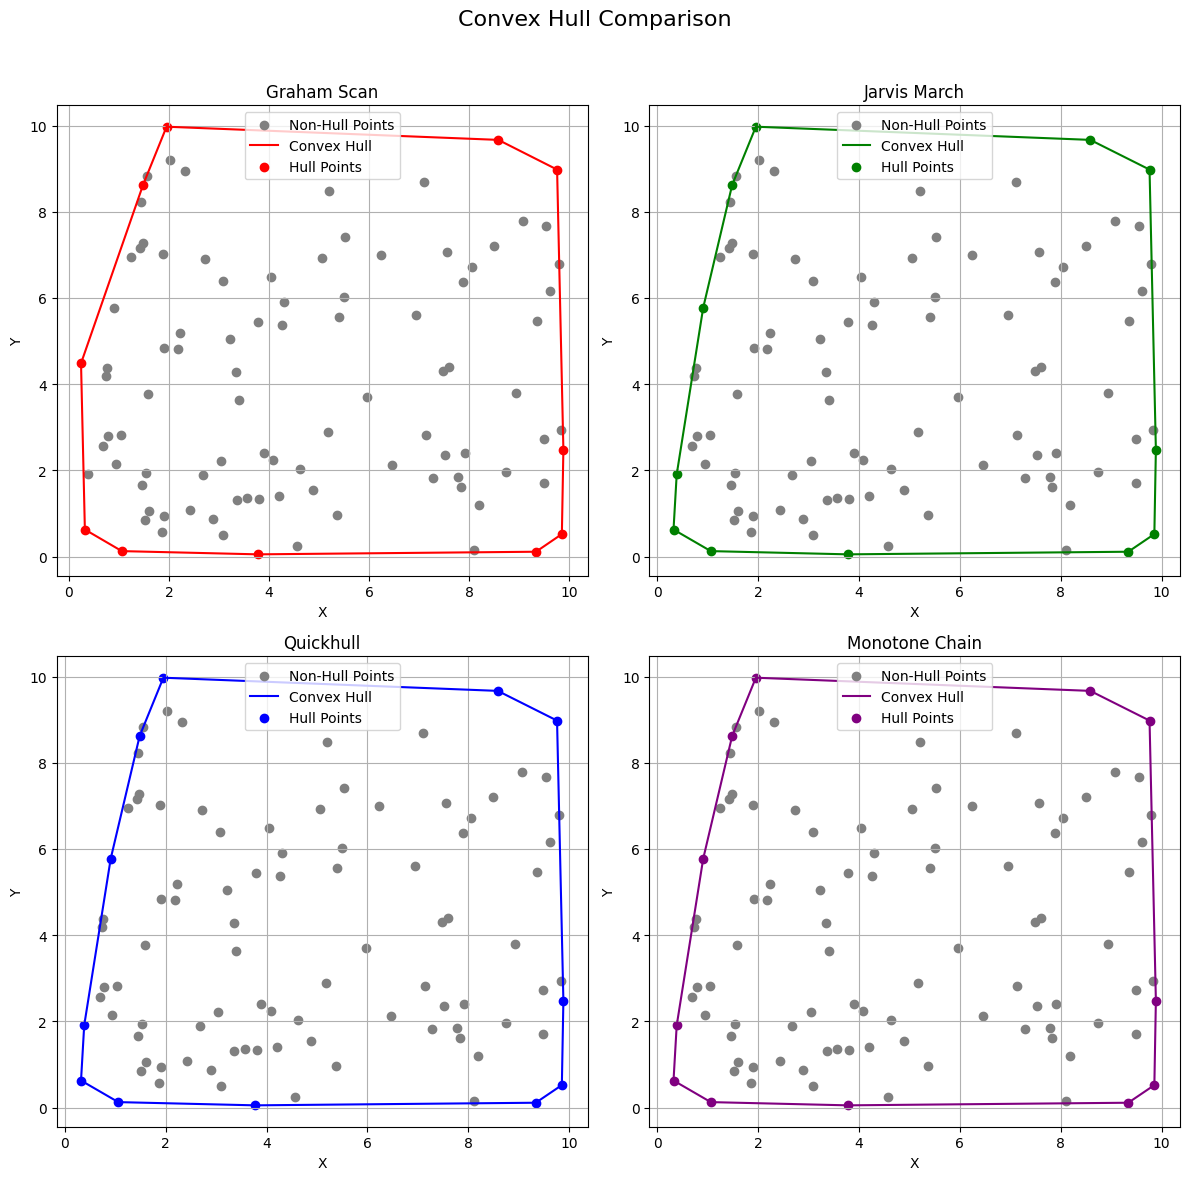

In [46]:
def plot_hulls_comparison(points):
    """ Plot convex hulls computed by four different algorithms in a 2x2 grid. """
    methods = {
        "Graham Scan": graham_convex_hull,
        "Jarvis March": jarvis_march,
        "Quickhull": quickhull,
        "Monotone Chain": monotone_chain
    }
    
    colors = ['red', 'green', 'blue', 'purple']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle("Convex Hull Comparison", fontsize=16)

    for ax, (method_name, method_func), color in zip(axes.flat, methods.items(), colors):
        hull = method_func(points)
        hull_set = set(hull)
        non_hull_points = [pt for pt in points if pt not in hull_set]

        # Plot non-hull points
        x_non_hull, y_non_hull = zip(*non_hull_points) if non_hull_points else ([], [])
        ax.scatter(x_non_hull, y_non_hull, color='gray', label='Non-Hull Points')

        # Plot convex hull points and edges
        x_hull, y_hull = zip(*hull)
        ax.plot(x_hull + (x_hull[0],), y_hull + (y_hull[0],), color=color, label='Convex Hull')
        ax.scatter(x_hull, y_hull, color=color, marker='o', label='Hull Points')

        # Formatting
        ax.set_title(method_name)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('4_convex_hulls.png')
    plt.show()

plot_hulls_comparison(points)

# Part 2: Time Complexity of a Point Cloud

**Part a)**

In [56]:
random.seed(42)

def generate_uniform_point_cloud(n):
    """Generate a 2D uniform point cloud with n points in the range [0,1] x [0,1]."""
    return [(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(n)]

**Part b)**

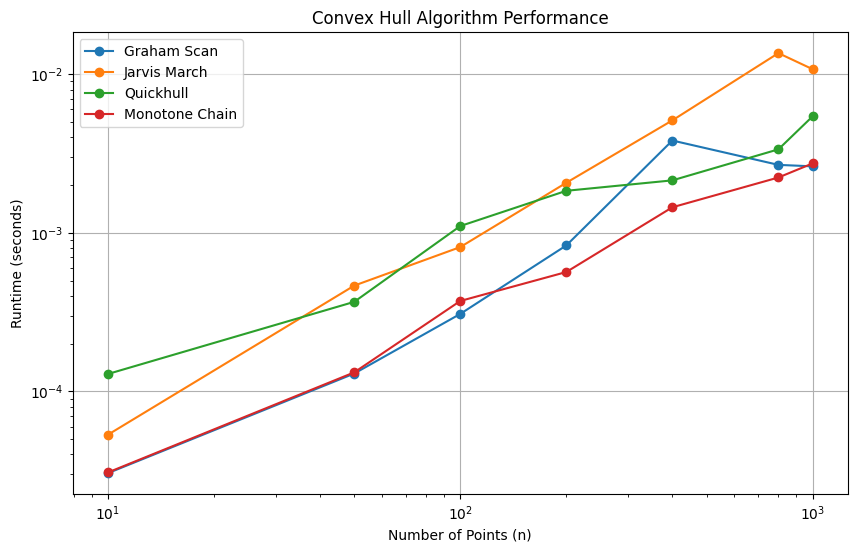

In [57]:
n_values = [10, 50, 100, 200, 400, 800, 1000]

# Store runtimes for each method
runtimes = {
    "Graham Scan": [],
    "Jarvis March": [],
    "Quickhull": [],
    "Monotone Chain": []
}

# Run each method for different values of n
for n in n_values:
    points = generate_uniform_point_cloud(n)

    for method_name, method_func in {
        "Graham Scan": graham_convex_hull,
        "Jarvis March": jarvis_march,
        "Quickhull": quickhull,
        "Monotone Chain": monotone_chain
    }.items():
        start_time = time.perf_counter()
        method_func(points)  # Compute convex hull
        end_time = time.perf_counter()

        runtimes[method_name].append(end_time - start_time)

# Plot the results
plt.figure(figsize=(10, 6))

for method, times in runtimes.items():
    plt.plot(n_values, times, marker='o', label=method)

plt.xlabel("Number of Points (n)")
plt.ylabel("Runtime (seconds)")
plt.title("Convex Hull Algorithm Performance")
plt.legend()
plt.grid(True)
plt.xscale("log")  # Log scale for better visualization of large n
plt.yscale("log")  # Log scale to capture performance differences
plt.savefig('convex_hull_time_comparison.png')
plt.show()

**Part c)**

In [38]:
# part c, bound points from -5 to 5
times = []

# Loop over each value of n
for n in n_values:
    # Generate random points
    points = generate_random_points(n, x_range=(-5, 5), y_range=(-5, 5))
    
    # Measure the time taken to compute the convex hull
    elapsed_time = measure_time_to_compute_hull(points)
    
    # Store the result
    times.append(elapsed_time)

print(times)

[4.00543212890625e-05, 0.00014853477478027344, 0.00035381317138671875, 0.001268625259399414, 0.005414247512817383, 0.0024313926696777344, 0.003937959671020508]


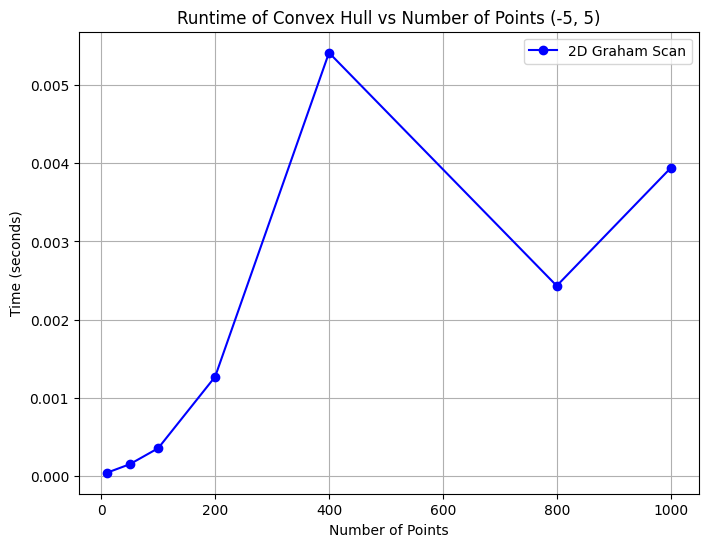

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(n_values, times, marker='o', color='b', linestyle='-', label='2D Graham Scan')
plt.xlabel('Number of Points')
plt.ylabel('Time (seconds)')
plt.title('Runtime of Convex Hull vs Number of Points (-5, 5)')
plt.grid(True)
plt.legend()
plt.show()

**Part d)**

# Task 2

**Part a)**

In [28]:
# Part a
def surface1(x, y):
    return 2*x**2+2*y**2

def surface2(x, y):
    return 2*np.exp(-x**2-y**2)

**Part b)**

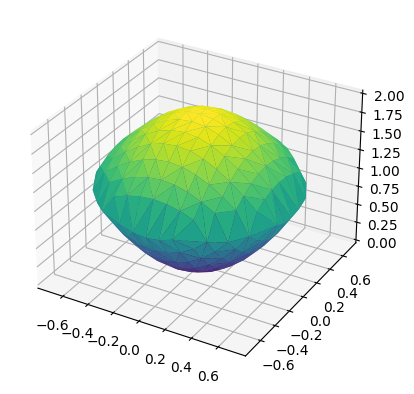

In [45]:
def triangle_area(x, y):
	return np.cross(x[1:] - x[0], y[1:] - y[0])/2

x = np.linspace(-1, 1, 21)
y = np.linspace(-1, 1, 21)
x, y = np.meshgrid(x, y)
indices = surface1(x, y) <= surface2(x, y) # identify that are in both surfaces

n = indices.sum()
x = x[indices]
y = y[indices]
triangles = Delaunay(np.c_[x, y]).simplices
triangles = [v for v in triangles if not np.isclose(triangle_area(x[v], y[v]), 0)]

edge_counter = Counter()
for vertices in triangles:
	i1, i2, i3 = sorted(vertices)
	edge_counter.update([(i1, i2), (i2, i3), (i1, i3)])
boundary = np.unique([edge for edge, count in edge_counter.items() if count == 1])
inner = np.setdiff1d(np.arange(n), boundary)

all_x = np.concatenate([x, x])
all_y = np.concatenate([y, y])
all_z = np.concatenate([surface1(x, y), surface2(x, y)])
all_triangles = np.concatenate([triangles, [[i if i in boundary else i+n for i in v] for v in triangles]])

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot_trisurf(all_x, all_y, all_z, triangles=all_triangles, cmap=cm.viridis)

plt.savefig("direct surface mesh.png", dpi=300)
plt.show()

**Part c)**

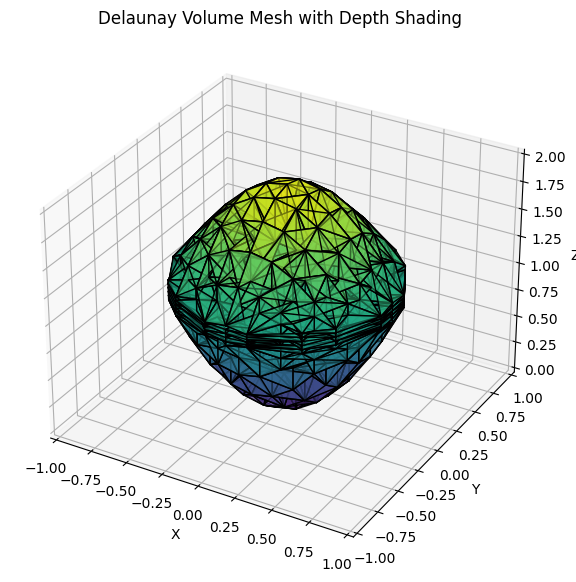

In [43]:
# Generate a 2D grid of points
x = np.linspace(-1, 1, 15)  # Reduced density for better visualization
y = np.linspace(-1, 1, 15)
x, y = np.meshgrid(x, y)

# Identify points within the valid overlapping region
indices = surface1(x, y) <= surface2(x, y)
x, y = x[indices], y[indices]

# Stack surface points into a 3D point cloud
top_points = np.c_[x, y, surface1(x, y)]
bottom_points = np.c_[x, y, surface2(x, y)]

# Create additional interior points using interpolation
num_layers = 5  # Controls the density of the volume mesh
all_points = [bottom_points]
for i in range(1, num_layers):
    fraction = i / num_layers
    interpolated_points = bottom_points * (1 - fraction) + top_points * fraction
    all_points.append(interpolated_points)
all_points.append(top_points)
all_points = np.vstack(all_points)  # Stack all layers into one array

# Perform 3D Delaunay triangulation
tri = Delaunay(all_points)

# Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Get colormap based on z-values for depth perception
z_values = all_points[:, 2]
norm = plt.Normalize(z_values.min(), z_values.max())
colors = cm.viridis(norm(z_values))  # Use a perceptually uniform colormap

# Plot tetrahedral edges with color mapping for depth perception
for simplex in tri.simplices:
    vertices = all_points[simplex]
    face_color = cm.viridis(norm(vertices[:, 2].mean()))  # Color based on average depth
    ax.add_collection3d(Poly3DCollection([vertices], facecolors=face_color, edgecolors="k", alpha=0.5))

# Set labels and limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Delaunay Volume Mesh with Depth Shading")

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 2])

plt.savefig("Delaunay volume mesh with depth shading.png", dpi=300)
plt.show()

**Part d)**

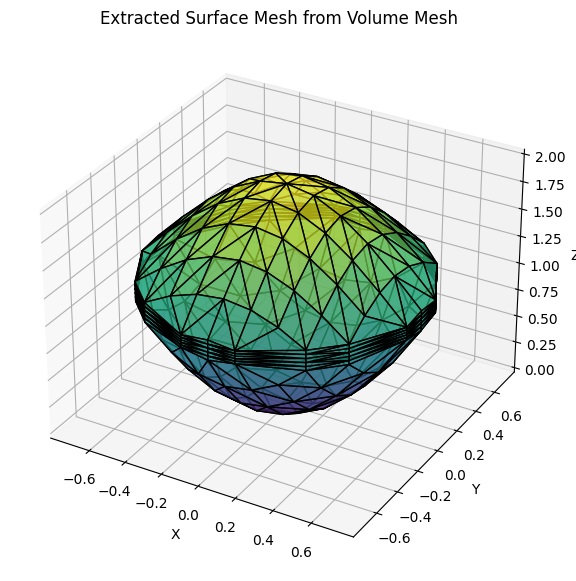

In [44]:
# Generate a 2D grid of points
x = np.linspace(-1, 1, 15)  # Adjust resolution for better visualization
y = np.linspace(-1, 1, 15)
x, y = np.meshgrid(x, y)

# Identify points within the valid overlapping region
indices = surface1(x, y) <= surface2(x, y)
x, y = x[indices], y[indices]

# Stack surface points into a 3D point cloud
top_points = np.c_[x, y, surface1(x, y)]
bottom_points = np.c_[x, y, surface2(x, y)]

# Create additional interior points using interpolation
num_layers = 5  # Adjust for density
all_points = [bottom_points]
for i in range(1, num_layers):
    fraction = i / num_layers
    interpolated_points = bottom_points * (1 - fraction) + top_points * fraction
    all_points.append(interpolated_points)
all_points.append(top_points)
all_points = np.vstack(all_points)  # Stack all layers into one array

# Perform 3D Delaunay triangulation
tri = Delaunay(all_points)

# **Extract surface mesh from volume mesh**
surface_triangles = set()
tetrahedra = tri.simplices

# Loop through all tetrahedra and track the faces
face_count = {}
for tet in tetrahedra:
    faces = [(tet[0], tet[1], tet[2]), (tet[0], tet[1], tet[3]), 
             (tet[0], tet[2], tet[3]), (tet[1], tet[2], tet[3])]
    
    for face in faces:
        sorted_face = tuple(sorted(face))  # Sort to avoid duplicate order issues
        if sorted_face in face_count:
            face_count[sorted_face] += 1
        else:
            face_count[sorted_face] = 1

# Collect only the faces that appear **exactly once** (surface triangles)
surface_triangles = [face for face, count in face_count.items() if count == 1]

# Convert list of tuples into NumPy array
surface_triangles = np.array(surface_triangles)

# **Visualization of the Surface Mesh**
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Use plot_trisurf to visualize the extracted surface
ax.plot_trisurf(all_points[:, 0], all_points[:, 1], all_points[:, 2], 
                triangles=surface_triangles, cmap="viridis", edgecolor="k", alpha=0.7)

# Set labels and limits
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Extracted Surface Mesh from Volume Mesh")

plt.savefig("Extracted Surface Mesh from Volume Mesh.png", dpi=300)
plt.show()

Direct surface mesh with Delaunay triangulation in part b) is a straightforward way to visualize the outer surface. The method in part d) also generates the interior volume mesh, and then visualizes the surface by identifying triangles on the outer boundary. 